In [1]:
# IMPORTAR LIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

### CARGAR DATOS

In [3]:
df_0 = pd.read_excel('PARATEC_Capacidadefectiva_27-10-2025.xlsx', sheet_name='CapacidadEfectiva_2', skiprows=7)

### LIMPIEZA DE DATOS

In [5]:
# 1. Eliminar las filas sin datos

ultimas_5 = df_0.columns[-5:]  # Selección de las últimas 5 columnas
df = df_0.dropna(subset=ultimas_5, how='all')

# 2. Cambiar el nombre de la columna por un nombre mas explicito
df = df.rename(columns={'Tipo/Fuente de energía': 'NombrePlanta'})

# 3. Convertir los datos de string a número
df['Capacidad efectiva neta [MW]'] = (
    df['Capacidad efectiva neta [MW]']
    .astype(str)
    .str.replace('.', '', regex=False)   # Quita separador de miles
    .str.replace(',', '.', regex=False)  # Cambia separador decimal
    .astype(float)
)

# 4. Convertir texto a fecha con formato día/mes/año
df['Fecha de puesta en operación FPO'] = pd.to_datetime(df['Fecha de puesta en operación FPO'], format='%d/%m/%Y', errors='coerce')

In [6]:
df.columns

Index(['NombrePlanta', 'FUENTE DE ENERGIA', 'Despacho', 'Generador',
       'Capacidad efectiva neta [MW]', 'Operador',
       'Fecha de puesta en operación FPO', 'Municipio', 'Departamento',
       'Subárea'],
      dtype='object')

### CALCULAR LA CAPACIDAD ACUMULADA

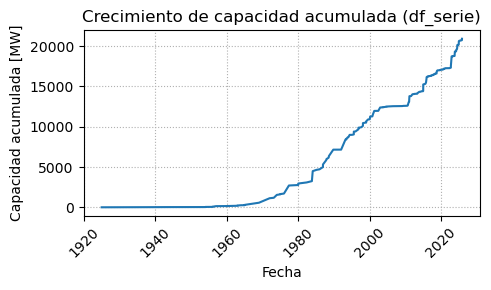

In [8]:
df_serie = df[['Fecha de puesta en operación FPO', 'Capacidad efectiva neta [MW]', 'FUENTE DE ENERGIA']].copy()

df_serie = df_serie.sort_values(by='Fecha de puesta en operación FPO', ascending=True).reset_index(drop=True)

# Crear la columna de capacidad acumulada
df_serie['Capacidad acumulada [MW]'] = df_serie['Capacidad efectiva neta [MW]'].cumsum()

# ==============================
# 1. FIGURA: df_serie
# ==============================
plt.figure(figsize=(5,3))
plt.plot(df_serie['Fecha de puesta en operación FPO'],
         df_serie['Capacidad acumulada [MW]'])
plt.xlabel('Fecha')
plt.ylabel('Capacidad acumulada [MW]')
plt.title('Crecimiento de capacidad acumulada (df_serie)')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

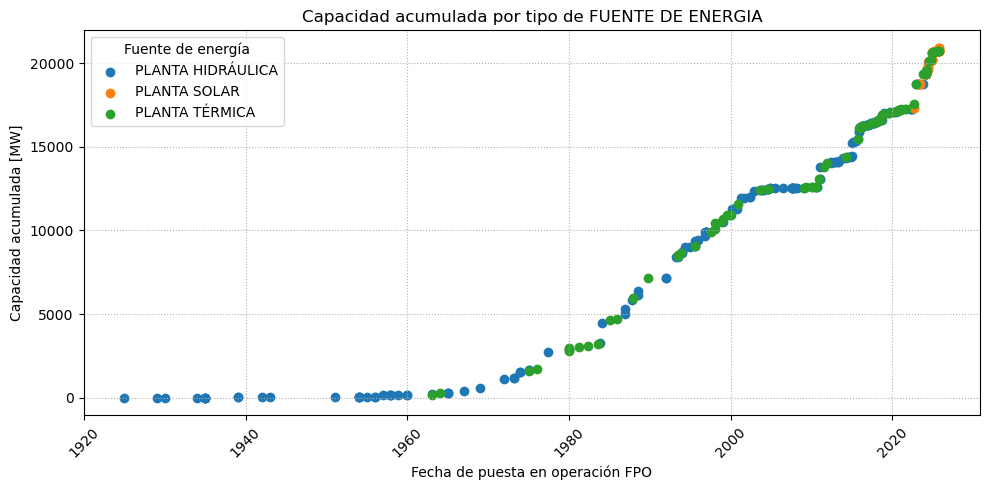

In [9]:
plt.figure(figsize=(10,5))

# Recorrer cada categoría de fuente energética y graficarla con una etiqueta
for fuente, df_sub in df_serie.groupby('FUENTE DE ENERGIA'):
    plt.scatter(df_sub['Fecha de puesta en operación FPO'],
                df_sub['Capacidad acumulada [MW]'],
                label=fuente)

plt.xlabel('Fecha de puesta en operación FPO')
plt.ylabel('Capacidad acumulada [MW]')
plt.title('Capacidad acumulada por tipo de FUENTE DE ENERGIA')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':')
plt.legend(title='Fuente de energía')
plt.tight_layout()
plt.show()

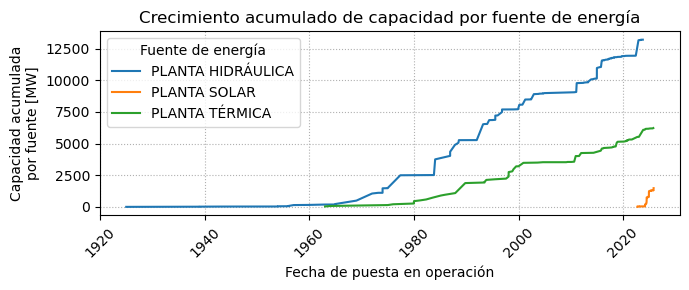

In [10]:
# Ordenar por fecha para garantizar correcta acumulación
df_acum_fuente = df_serie.sort_values(by='Fecha de puesta en operación FPO').copy()

# Acumulado por cada fuente de energía
df_acum_fuente['Capacidad acumulada por fuente [MW]'] = (
    df_acum_fuente
    .groupby('FUENTE DE ENERGIA')['Capacidad efectiva neta [MW]']
    .cumsum())

plt.figure(figsize=(7,3))

# Recorrer cada fuente energética y graficar su curva acumulada
for fuente, df_sub in df_acum_fuente.groupby('FUENTE DE ENERGIA'):
    plt.plot(df_sub['Fecha de puesta en operación FPO'],
             df_sub['Capacidad acumulada por fuente [MW]'],
             label=fuente)

plt.xlabel('Fecha de puesta en operación')
plt.ylabel('Capacidad acumulada\npor fuente [MW]')
plt.title('Crecimiento acumulado de capacidad por fuente de energía')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':')
plt.legend(title='Fuente de energía')
plt.tight_layout()
plt.show()

### CREAR UN DATAFRAME DIARIO FECHA-VALOR

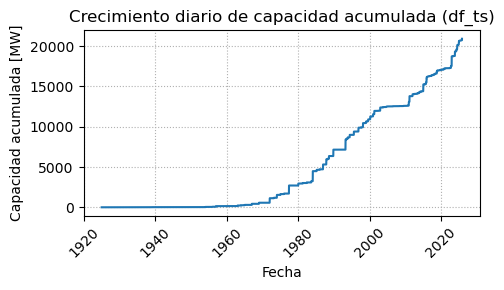

In [12]:
# 1. Tomar solo columnas necesarias
df_ts = df_serie[['Fecha de puesta en operación FPO', 'Capacidad acumulada [MW]']].copy()

# 2. Agrupar por fecha conservando el mayor valor si hay duplicados
df_ts = df_ts.groupby('Fecha de puesta en operación FPO').max()

# 3. Crear índice de fecha en orden creciente
df_ts = df_ts.sort_index()

# 4. Crear un rango diario desde la fecha mínima hasta la máxima
rango_fechas = pd.date_range(start=df_ts.index.min(), end=df_ts.index.max(), freq='D')

# 5. Reindexar al rango diario y rellenar faltantes con el último valor conocido
df_ts = df_ts.reindex(rango_fechas).ffill()

# 6. Renombrar índice a Fecha
df_ts.index.name = 'Fecha'

# ==============================
# 2. FIGURA: df_ts (serie diaria)
# ==============================
plt.figure(figsize=(5,3))
plt.plot(df_ts.index,
         df_ts['Capacidad acumulada [MW]'])
plt.xlabel('Fecha')
plt.ylabel('Capacidad acumulada [MW]')
plt.title('Crecimiento diario de capacidad acumulada (df_ts)')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

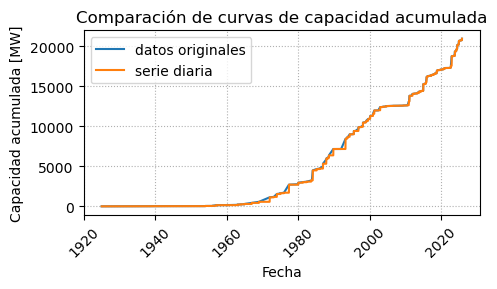

In [13]:
# ==============================
# 3. FIGURA: Comparación juntas
# ==============================
plt.figure(figsize=(5,3))
plt.plot(df_serie['Fecha de puesta en operación FPO'],
         df_serie['Capacidad acumulada [MW]'],
         label='datos originales')
plt.plot(df_ts.index,
         df_ts['Capacidad acumulada [MW]'],
         label='serie diaria')
plt.xlabel('Fecha')
plt.ylabel('Capacidad acumulada [MW]')
plt.title('Comparación de curvas de capacidad acumulada')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

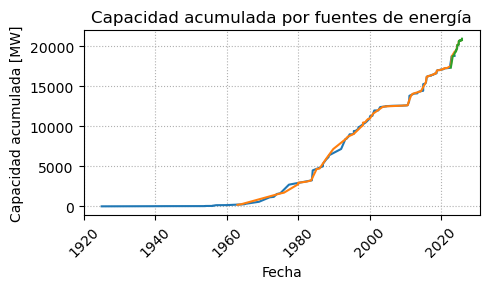

In [14]:
df_solar = df_serie[df_serie['FUENTE DE ENERGIA'] == 'PLANTA SOLAR'].copy()
df_hidraulica = df_serie[df_serie['FUENTE DE ENERGIA'] == 'PLANTA HIDRÁULICA'].copy()
df_termica = df_serie[df_serie['FUENTE DE ENERGIA'] == 'PLANTA TÉRMICA'].copy()

plt.figure(figsize=(5,3))
plt.plot(df_hidraulica['Fecha de puesta en operación FPO'], df_hidraulica['Capacidad acumulada [MW]'])
plt.plot(df_termica['Fecha de puesta en operación FPO'], df_termica['Capacidad acumulada [MW]'])
plt.plot(df_solar['Fecha de puesta en operación FPO'], df_solar['Capacidad acumulada [MW]'])
plt.xlabel('Fecha')
plt.ylabel('Capacidad acumulada [MW]')
plt.title('Capacidad acumulada por fuentes de energía')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()